Ng Ru Ying

In [60]:
# !pip install sqlalchemy
# !pip install PyMySQL

--- 
# 1. Connect to database & Load tables

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# <Credentials omitted>

database_conn = create_engine(f'mysql+pymysql://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DBNAME}', pool_recycle=3600)

# Check if connection is working
df = pd.read_sql('SELECT * FROM account;', database_conn)
df.head()

,account_id,customer_id,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,has_device_protection,contract_type,paperless_billing,payment_method
0,AAJU-HMJLK,0334-ZFJSR,55,0,Yes,Cable,No,Yes,Yes,Yes,Yes,Yes,No,One Year,Yes,Credit Card
1,AAKY-HUGJV,6235-VDHOM,5,0,Yes,DSL,Yes,No,No,No,No,Yes,No,Month-to-Month,No,Bank Withdrawal
2,AAMB-TJYWC,4006-HKYHO,63,0,Yes,DSL,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal
3,AANL-MWPZF,3258-SYSWS,72,0,Yes,Fiber Optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two Year,No,Bank Withdrawal
4,AAOS-KANBS,5360-XGYAZ,72,1,Yes,DSL,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal


In [62]:
df.to_csv('./data.csv')

## 1.1 Retrieve all columns from individual tables

In [63]:
# Individual tables
table_names = 'account account_usage churn_status city customer'.split(' ')
df_dict = {}
for table in table_names:
    df_dict[table] = pd.read_sql(f'SELECT * FROM {table};', database_conn)
# Names of tables in the database saved as dictionary keys
df_dict.keys()

Exception during reset or similar
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\pymysql\connections.py", line 782, in _read_bytes
    data = self._rfile.read(num_bytes)
  File "c:\ProgramData\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 682, in _finalize_fairy
    fairy._reset(pool)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 887, in _reset
    pool._dialect.do_rollback(self)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 667, in do_rollba

dict_keys(['account', 'account_usage', 'churn_status', 'city', 'customer'])

### 1.1.1 Check if account_id and customer_id are unique (prerequisite to combining tables correctly later)

In [64]:
# 1:1 or 1:m relationship between account and customer?
QUERY = '''
SELECT *
FROM account a 
RIGHT JOIN customer cust
    ON cust.customer_id = a.customer_id
'''

df = pd.read_sql(QUERY, database_conn)
df.isna().sum() == 0
# No nulls after join. Therefore every customer has a unique account id.

account_id                  True
customer_id                 True
tenure_months               True
num_referrals               True
has_internet_service        True
internet_type               True
has_unlimited_data          True
has_phone_service           True
has_multiple_lines          True
has_premium_tech_support    True
has_online_security         True
has_online_backup           True
has_device_protection       True
contract_type               True
paperless_billing           True
payment_method              True
customer_id                 True
gender                      True
age                         True
senior_citizen              True
married                     True
num_dependents              True
zip_code                    True
dtype: bool

## 1.2 Combine tables on relevant columns

In [65]:
churn_q2 = '''
SELECT *
FROM account a 
LEFT JOIN churn_status s
    ON s.customer_id = a.customer_id
LEFT JOIN account_usage u
    ON u.account_id = a.account_id
LEFT JOIN customer cust
    ON cust.customer_id = a.customer_id
LEFT JOIN city
    ON city.zip_code = cust.zip_code;
'''

all_df = pd.read_sql(churn_q2, database_conn)
# Remove duplicate columns
all_df = all_df.loc[:, ~all_df.columns.duplicated()]
all_df.status.value_counts()
all_df.nunique()

account_id                       7043
customer_id                      7043
tenure_months                      72
num_referrals                      12
has_internet_service                2
internet_type                       4
has_unlimited_data                  2
has_phone_service                   2
has_multiple_lines                  2
has_premium_tech_support            2
has_online_security                 2
has_online_backup                   2
has_device_protection               2
contract_type                       3
paperless_billing                   2
payment_method                      3
status                              3
churn_label                         3
churn_category                      6
churn_reason                       21
avg_long_distance_fee_monthly    3584
total_long_distance_fee          6068
avg_gb_download_monthly            50
stream_tv                           2
stream_movie                        2
stream_music                        2
total_monthl

In [66]:
df_dict['all'] = all_df

In [67]:
original_all_df = all_df.copy()

In [68]:
all_df.describe()

,tenure_months,num_referrals,avg_long_distance_fee_monthly,total_long_distance_fee,avg_gb_download_monthly,total_monthly_fee,total_charges_quarter,total_refunds,age,num_dependents,zip_code,area_id,latitude,longitude,population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.386767,1.951867,22.958954,749.099262,20.515405,64.761692,2280.381264,1.962182,46.509726,0.468692,93486.070567,767.045577,36.197455,-119.756684,22139.603294
std,24.542061,3.001199,15.448113,846.660055,20.418940,30.090047,2266.220462,7.902614,16.750352,0.962802,1856.767505,475.486842,2.468929,2.154425,21152.392837
min,1.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,19.000000,0.000000,90001.000000,1.000000,32.555828,-124.301372,11.000000
25%,9.000000,0.000000,9.210000,70.545000,3.000000,35.500000,400.150000,0.000000,32.000000,0.000000,92101.000000,350.000000,33.990646,-121.788090,2344.000000
50%,29.000000,0.000000,22.890000,401.440000,17.000000,70.350000,1394.550000,0.000000,46.000000,0.000000,93518.000000,741.000000,36.205465,-119.595293,17554.000000
75%,55.000000,3.000000,36.395000,1191.100000,27.000000,89.850000,3786.600000,0.000000,60.000000,0.000000,95329.000000,1182.000000,38.161321,-117.969795,36125.000000
max,72.000000,11.000000,49.990000,3564.720000,85.000000,118.750000,8684.800000,49.790000,80.000000,9.000000,96150.000000,1626.000000,41.962127,-114.192901,105285.000000


---
# 2. Data Cleaning

## 2.1 Replace binary values with 1 and 0, Stayed/Joined to 0, Churned to 1

In [69]:
# Replace all Yes and No as 0 and 1, and fill missing values with 0 in all tables
for name, table in df_dict.items():
    table.replace({'Yes': '1', 'No': '0'}, inplace=True)

In [70]:
df_dict['churn_status']['status'].replace({'Stayed': '0', 'Joined': '0', 'Churned': '1'}, inplace=True)
df_dict['all']['status'].replace({'Stayed': '0', 'Joined': '0', 'Churned': '1'}, inplace=True)

In [71]:
print(df_dict['all'].status.value_counts())
df_dict['all'].churn_label.value_counts()

0    5174
1    1869
Name: status, dtype: int64


0    5174
1    1817
       52
Name: churn_label, dtype: int64

From the above, we can see that the 'churn_label''s 52 missing values are 1 under 'status'. 

Thus, it is likely blank because they are churned, but not within the last month. Going by the definition of the column, we should set the missing values to 0.

## 2.2 Check for nulls and blanks

2.2.1 Null check - none found

In [72]:
# Null check
all_df.isna().sum()

account_id                       0
customer_id                      0
tenure_months                    0
num_referrals                    0
has_internet_service             0
internet_type                    0
has_unlimited_data               0
has_phone_service                0
has_multiple_lines               0
has_premium_tech_support         0
has_online_security              0
has_online_backup                0
has_device_protection            0
contract_type                    0
paperless_billing                0
payment_method                   0
status                           0
churn_label                      0
churn_category                   0
churn_reason                     0
avg_long_distance_fee_monthly    0
total_long_distance_fee          0
avg_gb_download_monthly          0
stream_tv                        0
stream_movie                     0
stream_music                     0
total_monthly_fee                0
total_charges_quarter            0
total_refunds       

2.2.2 Missing value check

In [73]:
# Missing value check
(all_df=='').sum()

account_id                          0
customer_id                         0
tenure_months                       0
num_referrals                       0
has_internet_service                0
internet_type                       0
has_unlimited_data                  0
has_phone_service                   0
has_multiple_lines                  0
has_premium_tech_support            0
has_online_security                 0
has_online_backup                   0
has_device_protection               0
contract_type                       0
paperless_billing                   0
payment_method                      0
status                              0
churn_label                        52
churn_category                   5174
churn_reason                     5174
avg_long_distance_fee_monthly       0
total_long_distance_fee             0
avg_gb_download_monthly             0
stream_tv                           0
stream_movie                        0
stream_music                        0
total_monthl

churn_status table has a big portion of missing values

1. 52 values under churn_label established to set to 0 (churned but not within last month)
2. 5174 category and reason are due to non-churned customers (same 5174 that are not churned). to set to "Unknown"

# 2.3 Filling missing values

In [74]:
import numpy as np

In [75]:
# Replace empty strings with NaN
for name, table in df_dict.items():
    table.replace('', np.nan, inplace=True)

In [76]:
def fill_nulls(df_list):
    for df in df_list:
        # Following the logic above, churn_label missing values should be 0
        df['churn_label']= df['churn_label'].fillna('0')
        # Churn category and reason are empty because 
        df['churn_category'] = df['churn_category'].fillna('N/A') 
        df['churn_reason'] = df['churn_reason'].fillna('N/A')

fill_nulls([df_dict['all'], df_dict['churn_status']])

df_dict['all'].isna().sum()


account_id                       0
customer_id                      0
tenure_months                    0
num_referrals                    0
has_internet_service             0
internet_type                    0
has_unlimited_data               0
has_phone_service                0
has_multiple_lines               0
has_premium_tech_support         0
has_online_security              0
has_online_backup                0
has_device_protection            0
contract_type                    0
paperless_billing                0
payment_method                   0
status                           0
churn_label                      0
churn_category                   0
churn_reason                     0
avg_long_distance_fee_monthly    0
total_long_distance_fee          0
avg_gb_download_monthly          0
stream_tv                        0
stream_movie                     0
stream_music                     0
total_monthly_fee                0
total_charges_quarter            0
total_refunds       

# 2.4 Change zip_code to object

In [77]:
df_dict['all']['zip_code'] = df_dict['all']['zip_code'].astype('object')

In [78]:
df_dict['all'].dtypes

account_id                        object
customer_id                       object
tenure_months                      int64
num_referrals                      int64
has_internet_service              object
internet_type                     object
has_unlimited_data                object
has_phone_service                 object
has_multiple_lines                object
has_premium_tech_support          object
has_online_security               object
has_online_backup                 object
has_device_protection             object
contract_type                     object
paperless_billing                 object
payment_method                    object
status                            object
churn_label                       object
churn_category                    object
churn_reason                      object
avg_long_distance_fee_monthly    float64
total_long_distance_fee          float64
avg_gb_download_monthly            int64
stream_tv                         object
stream_movie    

# 3. Data Exploration

In [79]:
import plotly.express as px

def plot_all_cols(df, color_col=None):
    # Plot for each column
    for column in df.columns:
        print(f"Value counts for {column}:\n", df[column].value_counts(), '\n---')

        num_distinct = df[column].nunique()

        # Case 1: Binary column, plot pie or grouped histogram
        if num_distinct == 2:
            if not color_col:
                # Pie chart for binary columns
                fig = px.pie(values=df[column].value_counts(),
                             names=df[column].value_counts().index,
                             title=f'{column} distribution')
            else:
                # Grouped histogram for binary columns and color_col specified
                fig = px.histogram(df, 
                                    x=column, 
                                    color=color_col,
                                    title=f'{column} distribution by {color_col}')
        
        # Case 2: More than 2 distinct values, handle counts per value
        else:
            # Group by and count occurrences
            if color_col:
                if color_col != column:
                    col_counts = df.groupby([column, color_col]).size().reset_index(name='Count')
                else:
                    col_counts = df.groupby([column]).size().reset_index(name='Count')
            else:
                col_counts = df.groupby([column]).size().reset_index(name='Count')

            # Line plot if the column is the same as color_col
            if color_col == column:
                fig = px.line(col_counts, 
                              x=column, 
                              y='Count', 
                              title=f'{column} counts over time', 
                              labels={column: column, 'Count': f'Count of {column}'}, 
                              hover_data={'Count': True})
            else:
                # Scatter plot for larger distinct values
                if num_distinct > 100:
                    fig = px.scatter(col_counts, 
                                     x=column, 
                                     y='Count', 
                                     color=color_col,
                                     title=f'{column} counts by {color_col}', 
                                     labels={column: column, 'Count': f'Count of {column}'}, 
                                     hover_data={'Count': True})
                else:
                    # Scatter chart for smaller distinct values
                    fig = px.line(col_counts, 
                                 x=column, 
                                 y='Count', 
                                 color=color_col, 
                                 title=f'{column} counts by {color_col}', 
                                 labels={column: column, 'Count': f'Count of {column}'}, 
                                 hover_data={'Count': True})

        # Show plot
        fig.show()

    # Return the first few rows of the DataFrame for reference
    return df.head()

In [80]:
all_df = df_dict['all']

In [81]:
all_df.columns

Index(['account_id', 'customer_id', 'tenure_months', 'num_referrals',
       'has_internet_service', 'internet_type', 'has_unlimited_data',
       'has_phone_service', 'has_multiple_lines', 'has_premium_tech_support',
       'has_online_security', 'has_online_backup', 'has_device_protection',
       'contract_type', 'paperless_billing', 'payment_method', 'status',
       'churn_label', 'churn_category', 'churn_reason',
       'avg_long_distance_fee_monthly', 'total_long_distance_fee',
       'avg_gb_download_monthly', 'stream_tv', 'stream_movie', 'stream_music',
       'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 'gender',
       'age', 'senior_citizen', 'married', 'num_dependents', 'zip_code',
       'area_id', 'city', 'latitude', 'longitude', 'population'],
      dtype='object')

In [82]:
plot_all_cols(df_dict['all'].drop(columns=['account_id',
                                           'customer_id',
                                           'status',
                                           'churn_reason',
                                           'paperless_billing',
                                           'has_unlimited_data',
       'has_phone_service', 'has_multiple_lines', 'has_premium_tech_support',
       'has_online_security', 'has_online_backup', 'has_device_protection',
       'stream_movie', 'stream_music',
              'avg_long_distance_fee_monthly', 'total_long_distance_fee',
              'married'
                                           ]), color_col = 'churn_label')
                                        
                                        

Value counts for tenure_months:
 1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: tenure_months, Length: 72, dtype: int64 
---


Value counts for num_referrals:
 0     3821
1     1086
5      264
3      255
7      248
9      238
4      236
2      236
10     223
6      221
8      213
11       2
Name: num_referrals, dtype: int64 
---


Value counts for has_internet_service:
 1    5517
0    1526
Name: has_internet_service, dtype: int64 
---


Value counts for internet_type:
 Fiber Optic    3035
DSL            1652
None           1526
Cable           830
Name: internet_type, dtype: int64 
---


Value counts for contract_type:
 Month-to-Month    3610
Two Year          1883
One Year          1550
Name: contract_type, dtype: int64 
---


Value counts for payment_method:
 Bank Withdrawal    3909
Credit Card        2749
Mailed Check        385
Name: payment_method, dtype: int64 
---


Value counts for churn_label:
 0    5226
1    1817
Name: churn_label, dtype: int64 
---


Value counts for churn_category:
 N/A                5174
Competitor          841
Attitude            314
Dissatisfaction     303
Price               211
Other               200
Name: churn_category, dtype: int64 
---


Value counts for avg_gb_download_monthly:
 0     1526
19     220
27     199
30     193
59     192
26     191
23     179
22     172
21     171
13     164
18     164
17     155
16     155
20     151
24     148
28     147
11     145
12     143
29     138
10     132
15     132
14     131
3      130
25     130
4      129
52     121
8      120
2      116
9      116
7      116
5      114
6      114
51      90
53      88
48      86
73      81
69      75
41      67
76      58
85      48
58      45
42      45
82      43
71      42
47      36
57      34
46      19
56      16
75      15
39       1
Name: avg_gb_download_monthly, dtype: int64 
---


Value counts for stream_tv:
 0    4336
1    2707
Name: stream_tv, dtype: int64 
---


Value counts for total_monthly_fee:
 20.05     61
19.85     45
19.90     44
19.95     44
19.70     43
          ..
93.95      1
63.75      1
31.00      1
92.65      1
106.95     1
Name: total_monthly_fee, Length: 1585, dtype: int64 
---


Value counts for total_charges_quarter:
 20.20      11
19.75       9
19.65       8
19.90       8
20.05       8
           ..
1066.15     1
8308.90     1
1347.15     1
3635.15     1
882.55      1
Name: total_charges_quarter, Length: 6540, dtype: int64 
---


Value counts for total_refunds:
 0.00     6518
18.39       2
32.55       2
16.56       2
47.04       2
         ... 
18.78       1
11.85       1
28.70       1
18.17       1
39.92       1
Name: total_refunds, Length: 500, dtype: int64 
---


Value counts for gender:
 Male      3555
Female    3488
Name: gender, dtype: int64 
---


Value counts for age:
 42    156
47    153
40    150
44    148
23    146
     ... 
80     66
78     63
66     63
67     61
72     58
Name: age, Length: 62, dtype: int64 
---


Value counts for senior_citizen:
 0    5901
1    1142
Name: senior_citizen, dtype: int64 
---


Value counts for num_dependents:
 0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
9       1
8       1
Name: num_dependents, dtype: int64 
---


Value counts for zip_code:
 92028    43
92027    38
92122    36
92117    34
92126    32
         ..
93528     2
91934     2
95431     2
96150     2
93711     1
Name: zip_code, Length: 1626, dtype: int64 
---


Value counts for area_id:
 325     43
324     38
370     36
365     34
373     32
        ..
745      2
300      2
1241     2
1626     2
828      1
Name: area_id, Length: 1626, dtype: int64 
---


Value counts for city:
 Los Angeles         293
San Diego           285
San Jose            112
Sacramento          108
San Francisco       104
                   ... 
Holtville             2
South Lake Tahoe      2
Johannesburg          2
Jacumba               2
Eldridge              2
Name: city, Length: 1106, dtype: int64 
---


Value counts for latitude:
 33.362575    43
33.141265    38
32.857230    36
32.825086    34
32.886925    32
             ..
35.363339     2
32.649787     2
38.348884     2
38.911577     2
36.833002     1
Name: latitude, Length: 1626, dtype: int64 
---


Value counts for longitude:
 -117.299644    43
-116.967221    38
-117.209774    36
-117.199424    34
-117.152162    32
               ..
-116.223700     2
-115.152865     2
-117.637641     2
-122.516990     2
-119.829470     1
Name: longitude, Length: 1625, dtype: int64 
---


Value counts for population:
 42239    43
48690    38
34902    36
51213    34
74232    32
         ..
73006     2
8062      2
207       2
363       2
36274     1
Name: population, Length: 1569, dtype: int64 
---


,tenure_months,num_referrals,has_internet_service,internet_type,contract_type,payment_method,churn_label,churn_category,avg_gb_download_monthly,stream_tv,...,gender,age,senior_citizen,num_dependents,zip_code,area_id,city,latitude,longitude,population
0,55,0,1,Cable,One Year,Credit Card,0,N/A,13,0,...,Female,41,0,0,92123,371,San Diego,32.808814,-117.134694,25232
1,63,0,1,DSL,Two Year,Bank Withdrawal,0,N/A,47,1,...,Male,24,0,0,93311,696,Bakersfield,35.162070,-119.194488,20440
2,72,0,1,Fiber Optic,Two Year,Bank Withdrawal,0,N/A,26,1,...,Male,75,1,0,92040,329,Lakeside,32.909873,-116.906774,42277
3,72,4,0,None,Two Year,Bank Withdrawal,0,N/A,0,0,...,Female,59,0,3,95555,1310,Orick,41.336354,-124.044354,494
4,38,0,0,None,Two Year,Credit Card,0,N/A,0,0,...,Female,43,0,0,93304,690,Bakersfield,35.339796,-119.023552,44588


# 4. Drop columns

In [83]:
all_df_clean = all_df.drop(columns=['gender', # not much trends seen
                                            'account_id', 'customer_id', # not needed for analysis
                                            'status','churn_category','churn_reason', # will not be known in new data
                                            ])
all_df_clean.columns

Index(['tenure_months', 'num_referrals', 'has_internet_service',
       'internet_type', 'has_unlimited_data', 'has_phone_service',
       'has_multiple_lines', 'has_premium_tech_support', 'has_online_security',
       'has_online_backup', 'has_device_protection', 'contract_type',
       'paperless_billing', 'payment_method', 'churn_label',
       'avg_long_distance_fee_monthly', 'total_long_distance_fee',
       'avg_gb_download_monthly', 'stream_tv', 'stream_movie', 'stream_music',
       'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 'age',
       'senior_citizen', 'married', 'num_dependents', 'zip_code', 'area_id',
       'city', 'latitude', 'longitude', 'population'],
      dtype='object')

# 5. Data Transformation

## 5.1 Standard Scaling - Standard scaling is skipped in consideration of new data

In [84]:
# all_df_clean.select_dtypes(include=['float','int']).columns()
# '''
# Standard Scaling is needed for 'tenure_months', 'avg_long_distance_fee_monthly',
#        'total_long_distance_fee', 'avg_gb_download_monthly',
#        'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 'age'
# '''

In [85]:
# all_df_clean.select_dtypes(include=['float','int']).columns

In [86]:
# from sklearn.preprocessing import StandardScaler
# scale_cols = ['tenure_months', 'avg_long_distance_fee_monthly',
#        'total_long_distance_fee', 'avg_gb_download_monthly',
#        'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 'age'
#               ]
# # Initialize the StandardScaler
# scaler = StandardScaler()
# # Apply standard scaling to the numeric columns
# all_df_clean[scale_cols] = scaler.fit_transform(all_df_clean[scale_cols])

# px.box(all_df_clean[scale_cols])

## 5.1 One Hot Encoding
From the visualizations, the churn category and churn reason is rather similar. Thus, one hot encoding is chosen on churn category, and churn_reason will be dropped later.

One Hot Encoding was chosen over Label Encoding in the event the labels accidentally gave more precedence (e.g. contract type, a value of 2 may give more emphasis to the '2 Year' value instead of treating all values equally)

In [87]:
unique_count = all_df_clean.select_dtypes(include=['object']).nunique()
unique_count[unique_count>2]
# To one hot encode: zip_code, internet_type, contract_type, payment_method

internet_type        4
contract_type        3
payment_method       3
zip_code          1626
city              1106
dtype: int64

In [88]:
# One Hot Encoding
def one_hot_encode(df, col_list):
    for col in col_list:
        dummies = pd.get_dummies(df[col], drop_first=True).astype(float)  # Convert bool to 0 and 1
        dummies.columns = [f"{col}_{val}" for val in dummies.columns]
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
    return df

columns_encode = ('zip_code, internet_type, contract_type, payment_method').split(', ')

all_df_encoded = one_hot_encode(all_df_clean, columns_encode)

In [89]:
all_df_encoded.dtypes

tenure_months                    int64
num_referrals                    int64
has_internet_service            object
has_unlimited_data              object
has_phone_service               object
                                ...   
internet_type_None             float64
contract_type_One Year         float64
contract_type_Two Year         float64
payment_method_Credit Card     float64
payment_method_Mailed Check    float64
Length: 1662, dtype: object

# 6. Change back int to float for ML

In [90]:
all_df_encoded.columns

Index(['tenure_months', 'num_referrals', 'has_internet_service',
       'has_unlimited_data', 'has_phone_service', 'has_multiple_lines',
       'has_premium_tech_support', 'has_online_security', 'has_online_backup',
       'has_device_protection',
       ...
       'zip_code_96146', 'zip_code_96148', 'zip_code_96150',
       'internet_type_DSL', 'internet_type_Fiber Optic', 'internet_type_None',
       'contract_type_One Year', 'contract_type_Two Year',
       'payment_method_Credit Card', 'payment_method_Mailed Check'],
      dtype='object', length=1662)

In [91]:
def convert_float(df):
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except ValueError as e:
            print(f"Error in column '{col}': {e}")
            non_numeric_values = df[col][~df[col].isnull() & ~df[col].apply(lambda x: isinstance(x, (int, float)))]
            if len(non_numeric_values) > 0:
                print(f"Column '{col}' contains non-numeric values:")
    print(df.iloc[:,:5].dtypes)
    return df

all_df_encoded = convert_float(all_df_encoded)

Error in column 'city': could not convert string to float: 'San Diego'
Column 'city' contains non-numeric values:
tenure_months           float64
num_referrals           float64
has_internet_service    float64
has_unlimited_data      float64
has_phone_service       float64
dtype: object


# 7. Machine Learning
## 7.1 Data preparation

In [92]:
train_df_encoded = all_df_encoded.copy()
train_df_encoded.columns = train_df_encoded.columns.astype(str)

In [93]:
from sklearn.model_selection import train_test_split
def split_data(df: pd.DataFrame,
               y: str = None,
               train:str ='Y'):
    features = df.columns.tolist()
    features.remove(y)
    X = df[features]
    y = df[y]
    if train=='Y':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    else:
        X_train, X_test, y_train, y_test = None, None, None, None
    return features, X, y, X_train, X_test, y_train, y_test

features, X, y, X_train, X_test, y_train, y_test = split_data(train_df_encoded.select_dtypes(include=['int','float']),
                                                              y='churn_label',
                                                              train='Y'
                                                              )
X_train.head(5)

,tenure_months,num_referrals,has_internet_service,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,has_device_protection,...,zip_code_96146,zip_code_96148,zip_code_96150,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,contract_type_One Year,contract_type_Two Year,payment_method_Credit Card,payment_method_Mailed Check
3580,72.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2364,5.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6813,26.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
789,17.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
561,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [94]:
Xdf = train_df_encoded[features].select_dtypes(include=['int','float'])
Xdf.dtypes

tenure_months                  float64
num_referrals                  float64
has_internet_service           float64
has_unlimited_data             float64
has_phone_service              float64
                                ...   
internet_type_None             float64
contract_type_One Year         float64
contract_type_Two Year         float64
payment_method_Credit Card     float64
payment_method_Mailed Check    float64
Length: 1660, dtype: object

## 7.2 Clustering

WCSS for k = 1 : 3193581724552.582
WCSS for k = 2 : 951809266021.9166
WCSS for k = 3 : 461941655129.0544
WCSS for k = 4 : 273738267470.5715
WCSS for k = 5 : 193277126547.2606
WCSS for k = 6 : 147426706814.7892
WCSS for k = 7 : 118604999028.1145
WCSS for k = 8 : 99810797873.5835
[1.75190485e+12 3.01664223e+11 1.07742247e+11 3.46107212e+10
 1.70287119e+10 1.00275066e+10]
Index when value first increases: 1
n_clusters =  3


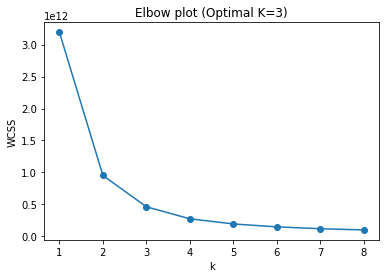

In [95]:
import numpy as np
from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

wcss_vals = []
# silhouette_scores = []

Xdf = train_df_encoded[features].select_dtypes(include=['float'])
Xdf.columns = Xdf.columns.astype(str)
min_cluster = 1
max_cluster = 9


for k in range(min_cluster, max_cluster):
    kmeans_model = KMeans(n_clusters = k, random_state = 0).fit(Xdf)
    wcss = kmeans_model.inertia_
    wcss_vals.append(wcss)
    print('WCSS for k =', k, ':', round(wcss, 4))


# Get inflexion point of wcss
slopes = np.diff(wcss_vals) / np.diff(range(len(wcss_vals)))
slopes_2 = np.diff(slopes) / np.diff(range(len(slopes)))
print(slopes_2)
increasing_index = next((i for i in range(1, len(slopes_2)) if slopes_2[i] < slopes_2[i - 1]), None) # index where it first changes from decreasing to increasing slope (inflexion)
n_clusters = increasing_index+2
print("Index when value first increases:", increasing_index)
print('n_clusters = ', n_clusters)

# Simple matplotlib graph
import matplotlib.pyplot as plt
plt.title(f"Elbow plot (Optimal K={n_clusters})")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.plot(range(min_cluster, max_cluster), wcss_vals, '-o')
# plt.plot(cluster_size_range, silhouette_scores, '-o')
plt.show()

NUM_CLUSTERS = n_clusters
kmeans = KMeans(n_clusters = NUM_CLUSTERS, random_state = 0)
cluster_labels = kmeans.fit_predict(Xdf)

from sklearn.decomposition import PCA
# run PCA for visualization of clusters on 2D graph
def plotPCA(dataset, cluster_labels, k):
    pca_output = PCA(n_components = 2, random_state = 0).fit_transform(dataset)

    pca_plot_df = dataset.copy()
    pca_plot_df['labels'] = cluster_labels
    pca_plot_df['pca1'] = pca_output[:,0]
    pca_plot_df['pca2'] = pca_output[:,1]
    plt.show()
plotPCA(Xdf, cluster_labels, NUM_CLUSTERS)

train_df_encoded_c = train_df_encoded.copy()
train_df_encoded_c['cluster_labels'] = cluster_labels
#train_df_encoded_c = train_df_encoded_c[train_df_encoded_c['cluster_labels']!=1]# .drop(columns='cluster_labels')
featuresc, Xc, yc, X_trainc, X_testc, y_trainc, y_testc = split_data(train_df_encoded_c, 
                                                                     y='churn_label',
                                                                     train='Y')

## 7.1 Instantiate models


In [96]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(random_state=0)

# Model 2: Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
params = {
    'learning_rate': 0.5967511656638482,
    'max_depth': 2,
    'max_features': 60,
    'max_leaf_nodes': 381,
    'min_samples_leaf': 9,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.007818203370596966
}
gbc_model = GradientBoostingClassifier(**params, random_state=5)

# Model 3: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=5, n_estimators=100)

# Model 4: Cat Boost Classifier
from catboost import CatBoostClassifier
cbc_model = CatBoostClassifier(learning_rate=0.1, random_state=5, verbose=0)

In [97]:
from sklearn import metrics
import time

model_list = [logreg_model, 
              gbc_model,
              random_forest_model,
              cbc_model,
              ]
model_names = ['LogisticRegression', 
               'GradientBoostingClassifier',
               'RandomForestClassifier',
               'CatBoostClassifier',
               ]

final_result = {'AUC':{},
                'Accuracy':{},
                'model': {}
                } 
i=0
for model in model_list:
    print(i)
    start_time = time.time()
    model_name = model_names[i]
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    final_result['AUC'][model_name] = auc_score
    if model_name == 'RandomForestClassifier':
        print('Number of Trees used : ', model.n_estimators)
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    final_result['Accuracy'][model_name]= accuracy_score
    final_result['model'][model_name] = model
    end_time = time.time()
    print('##### Model:', model_name)
    print('AUC:', auc_score)
    print('Accuracy_score:', accuracy_score)
    print('Time taken:', (end_time - start_time)/60, 'mins\n')
    i+=1
    

0


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



##### Model: LogisticRegression
AUC: 0.8057745800599452
Accuracy_score: 0.79649787032655
Time taken: 0.02866690158843994 mins

1
##### Model: GradientBoostingClassifier
AUC: 0.9003829834132363
Accuracy_score: 0.8457169900615239
Time taken: 0.00998393694559733 mins

2
Number of Trees used :  100
##### Model: RandomForestClassifier
AUC: 0.8879123630447961
Accuracy_score: 0.8466635115948887
Time taken: 0.09619988203048706 mins

3
##### Model: CatBoostClassifier
AUC: 0.9053921956198294
Accuracy_score: 0.8566019876952201
Time taken: 0.21199636061986288 mins



In [98]:
final_result

{'AUC': {'LogisticRegression': 0.8057745800599452,
  'GradientBoostingClassifier': 0.9003829834132363,
  'RandomForestClassifier': 0.8879123630447961,
  'CatBoostClassifier': 0.9053921956198294},
 'Accuracy': {'LogisticRegression': 0.79649787032655,
  'GradientBoostingClassifier': 0.8457169900615239,
  'RandomForestClassifier': 0.8466635115948887,
  'CatBoostClassifier': 0.8566019876952201},
 'model': {'LogisticRegression': LogisticRegression(random_state=0),
  'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.5967511656638482, max_depth=2,
                             max_features=60, max_leaf_nodes=381,
                             min_samples_leaf=9,
                             min_weight_fraction_leaf=0.007818203370596966,
                             random_state=5),
  'RandomForestClassifier': RandomForestClassifier(random_state=5),
  'CatBoostClassifier': <catboost.core.CatBoostClassifier at 0x2e81fa22d00>}}

# 8. Search CVs
Both GradientBoosting and CatBoost performed well. Optimise both to see if any performs even better than the other.

In [99]:
# Code to optimise using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
def randomize_search(MODEL_NAME, search_params, final_result,
                     X_train=X_train,
                     X_test=X_test,
                     y_test=y_test,
                     ):
    ACCURACY = final_result['Accuracy'][MODEL_NAME]
    AUC = final_result['AUC'][MODEL_NAME]

    # Set up the RandomizedSearchCV
    random_search = RandomizedSearchCV(**search_params)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Print the best parameters and the best score
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best cross-validation accuracy: {random_search.best_score_}")

    # Evaluate on the test set
    y_pred = random_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    y_pred_proba = random_search.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    print(f"""Test accuracy: {test_accuracy}
    Original accuracy: {ACCURACY}
    Test AUC: {auc_score}
    Original AUC: {AUC}
    """)

    diff_acc = test_accuracy - ACCURACY
    diff_auc = auc_score-AUC

    if (diff_acc or diff_auc) > 0:
        print('Improved!')
    else:
        print('Did not improve.')
    result = {'model_name': MODEL_NAME,
              'optimised_model': random_search.best_estimator_,
              'all_result':random_search,
              'best_params':random_search.best_params_,
              'best_cross validation accuracy': random_search.best_score_,
              'y_pred': y_pred,
              'y_pred_proba': y_pred_proba,
              'test auc_score': auc_score,
              'original auc': AUC,
              'test accuracy': test_accuracy,
              'original accuracy': ACCURACY,
              }
    # print(result)
    return result

## 8.1 Optimise GradientBoostingClassifier

In [100]:
# Optimise GradientBoostingClassifier
CHOSEN = 'GradientBoostingClassifier'
gb_model = final_result['model'][CHOSEN]

# Define the hyperparameter search space
param_dist = {
    'learning_rate': [0.1, 0.3, 0.5, 0.6], 
    'max_depth': [2, 3, 4],  
    'max_features': ['sqrt', 'log2', 0.5, 0.6],  
    'max_leaf_nodes': [100, 200, 300, 400], 
    'min_samples_leaf': [5, 7, 9, 10], 
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.005, 0.01, 0.02]
}

search_params = {
    'estimator': gb_model,
    'param_distributions': param_dist,
    'n_iter':20,
    'scoring':'roc_auc',  # Optimize for AUC instead of accuracy
    'cv':3,  # 3-fold cross-validation
    'verbose':1,
    'n_jobs':-1,  # Use all available CPU cores
    'random_state':42,
    'return_train_score':True,
    'error_score':'raise'
}

gb_result = randomize_search('GradientBoostingClassifier',
                             search_params,
                             final_result)
# 1min 23.2s

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'min_weight_fraction_leaf': 0.02, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 300, 'max_features': 0.6, 'max_depth': 4, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9053587306597635
Test accuracy: 0.8618078561287269
    Original accuracy: 0.8457169900615239
    Test AUC: 0.9117664675680013
    Original AUC: 0.9003829834132363
    
Improved!


## 8.2 Optimise CatBoostingClassifier

In [101]:
from sklearn.model_selection import StratifiedKFold
CHOSEN = 'CatBoostClassifier'
cat_model = final_result['model'][CHOSEN]
# Define the parameter distribution for RandomizedSearchCV
param_dist_c = {
    'iterations': [100, 200, 300, 500],  # Number of boosting iterations
    'depth': [4, 5, 6, 7, 8],  # Tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of data to use for training each tree
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],  # Fraction of features per level
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 regularization term
    'loss_function': ['Logloss']  # Use Logloss for binary classification
}

# Set up RandomizedSearchCV with 3-fold stratified cross-validation
search_params_c = {
    'estimator': cat_model,
    'param_distributions': param_dist_c,
    'n_iter': 20,
    'scoring': 'accuracy',
    'cv': StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Stratified k-fold cross-validation
    'verbose': 1,
    'n_jobs': -1,  # Use all available CPU cores
    'random_state': 42,
    'return_train_score': True
}
catboost_result = randomize_search('CatBoostClassifier',
                             search_params_c,
                             final_result)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 0.9, 'loss_function': 'Logloss', 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 5, 'colsample_bylevel': 1.0}
Best cross-validation accuracy: 0.8525340862140202
Test accuracy: 0.8580217699952674
    Original accuracy: 0.8566019876952201
    Test AUC: 0.912926079529255
    Original AUC: 0.9053921956198294
    
Improved!


Based on tests, although CatBoostClassifier performed better initially, the accuracy scores after optimisation are almost the same or lower than GradientBoostingClassifier, and took a longer time. Thus, GradientBoostingClassifier is chosen.

```
GradientBoostingClassifier
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'min_weight_fraction_leaf': 0.02, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 300, 'max_features': 0.6, 'max_depth': 4, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9053587306597635
Test accuracy: 0.8618078561287269
Original accuracy: 0.8457169900615239
Test AUC: 0.9117664675680013
Original AUC: 0.9003829834132363

Improved!
CatBoostClassifier
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 0.9, 'loss_function': 'Logloss', 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 5, 'colsample_bylevel': 1.0}
Best cross-validation score: 0.8525340862140202
Test accuracy: 0.8580217699952674
Original accuracy: 0.8566019876952201
Test AUC: 0.912926079529255
Original AUC: 0.9053921956198294

Improved!
```

## 9. Pickle

In [102]:
from pathlib import Path

Path("../model").mkdir(exist_ok=True)  # Create model/ directory if doesn't exist

In [103]:
import joblib
# Save model
joblib.dump(gb_result['optimised_model'], f'../model/model.pkl')
print(f"Model has been saved successfully.")
gb_result['optimised_model']

Model has been saved successfully.


GradientBoostingClassifier(max_depth=4, max_features=0.6, max_leaf_nodes=300,
                           min_samples_leaf=10, min_weight_fraction_leaf=0.02,
                           random_state=5)

# 10. Load Model

In [104]:
model = joblib.load('../model/model.pkl')
model

GradientBoostingClassifier(max_depth=4, max_features=0.6, max_leaf_nodes=300,
                           min_samples_leaf=10, min_weight_fraction_leaf=0.02,
                           random_state=5)

# 9. SHAP - feature importance

In [105]:
# !pip install shap

In [106]:
import shap
shap.initjs()

In [107]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

In [108]:
all_df_clean.columns

Index(['tenure_months', 'num_referrals', 'has_internet_service',
       'internet_type', 'has_unlimited_data', 'has_phone_service',
       'has_multiple_lines', 'has_premium_tech_support', 'has_online_security',
       'has_online_backup', 'has_device_protection', 'contract_type',
       'paperless_billing', 'payment_method', 'churn_label',
       'avg_long_distance_fee_monthly', 'total_long_distance_fee',
       'avg_gb_download_monthly', 'stream_tv', 'stream_movie', 'stream_music',
       'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 'age',
       'senior_citizen', 'married', 'num_dependents', 'zip_code', 'area_id',
       'city', 'latitude', 'longitude', 'population'],
      dtype='object')

TypeError: set_ticks() got an unexpected keyword argument 'fontsize'

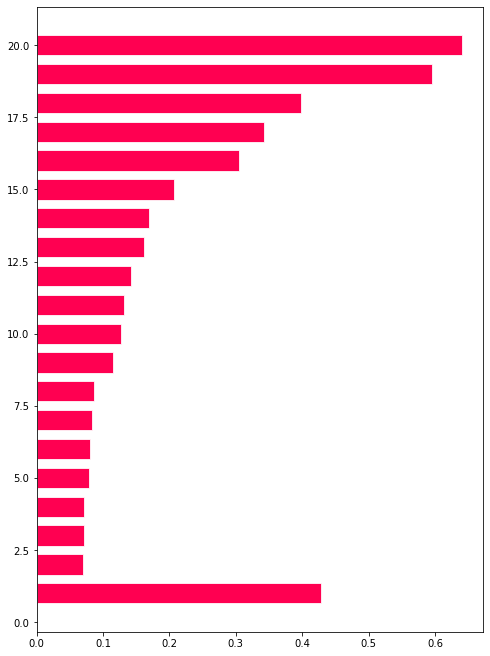

In [117]:
shap.plots.bar(shap_values.abs.mean(0), max_display=20)

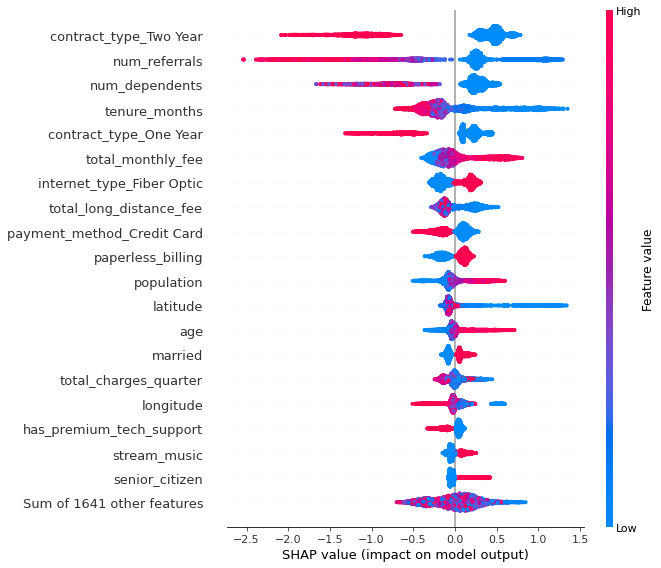

In [110]:
shap.plots.beeswarm(shap_values, max_display=20,)

**Top 15 features to consider as fields in website**
contract_type,
num_referrals,
num_dependents,
tenure_months,
total_monthly_fee,
internet_type,
total_long_distance_fee,
payment_method,
paperless_billing,
age,
married

1. contract_type
2. num_referrals
3. num_dependents
4. tenure_months
5. married
6. total_monthly_fee
7. internet_type
8. payment method
9. age
10. total_long_distance_fee
11. has_premium_tech_support
12. population
13. longitude/ latitude/ area_id
14. stream_tv
15. has_multiple_lines